In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
import os

In [61]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
#feature image path
feature_img_path = "Track1/train/images/10.tif"
# Load the feature tif image with multibands
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()
#check if the image is loaded
if feature_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(feature_img.shape))

#load the label image
label_img_path = "Track1/train/labels/10.png"
#load the label image
with rasterio.open(label_img_path) as src:
    label_img = src.read()
#check if the image is loaded
if label_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(label_img.shape))

Feature image size: (6, 512, 512)
Feature image size: (1, 512, 512)


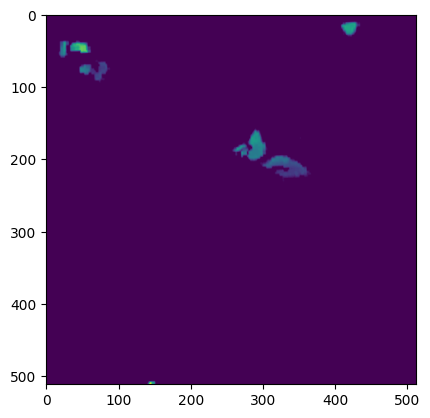

In [65]:
#display the image
plt.imshow(feature_img[5])

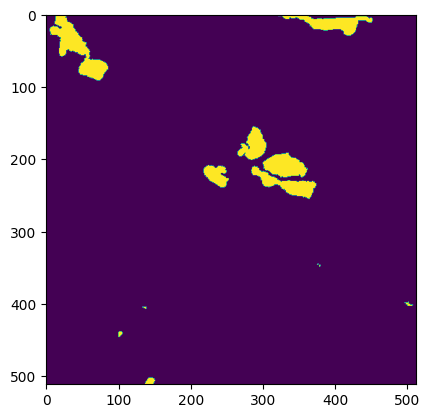

In [42]:
#display the label image
plt.imshow(label_img[0])

Feature image shape: (6, 512, 512) (Bands, Height, Width)


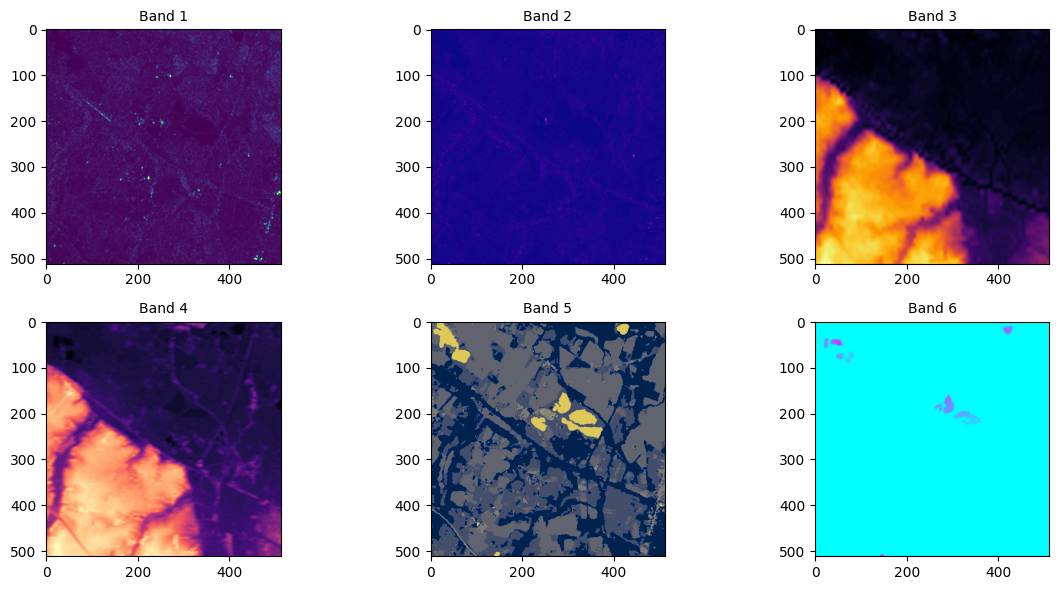

Label image shape: (512, 512) (Height, Width)


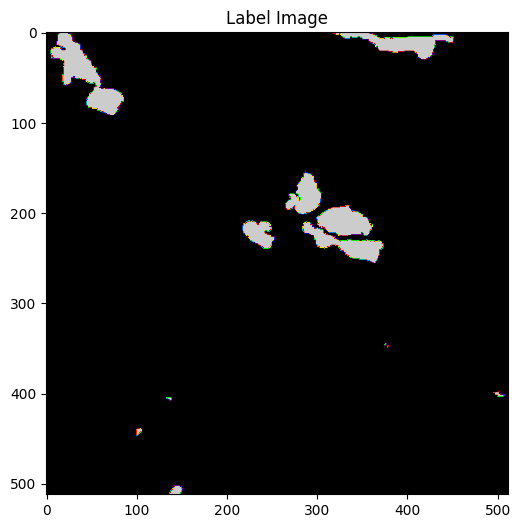

In [70]:
import rasterio
import matplotlib.pyplot as plt

# === Load feature image ===
feature_img_path = "Track1/train/images/10.tif"
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()  # (Bands, H, W)

if feature_img is None:
    print("Error: Feature image not found")
else:
    print(f"Feature image shape: {feature_img.shape} (Bands, Height, Width)")

    # Use different colormaps for visualization
    cmaps = [
        'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool',
        'spring', 'summer', 'autumn', 'winter', 'hot', 'turbo'
    ]
    
    num_bands = feature_img.shape[0]
    fig, axes = plt.subplots(nrows=(num_bands + 2) // 3, ncols=3, figsize=(12, 3 * ((num_bands + 2) // 3)))
    axes = axes.flatten()

    for i in range(num_bands):
        axes[i].imshow(feature_img[i], cmap=cmaps[i % len(cmaps)])
        axes[i].set_title(f'Band {i + 1}', fontsize=10)
        axes[i].axis()

    for j in range(num_bands, len(axes)):
        axes[j].axis()  # Hide any unused axes
    plt.tight_layout()
    plt.show()

# === Load label image ===
label_img_path = "Track1/train/labels/10.png"
with rasterio.open(label_img_path) as src:
    label_img = src.read(1)  # Read as grayscale (assumes labels are class indices)

if label_img is None:
    print("Error: Label image not found")
else:
    print(f"Label image shape: {label_img.shape} (Height, Width)")

    # Display label image with colorful colormap
    plt.figure(figsize=(6, 6))
    plt.imshow(label_img, cmap='nipy_spectral')
    plt.title("Label Image", fontsize=12)
    plt.axis()
    plt.show()

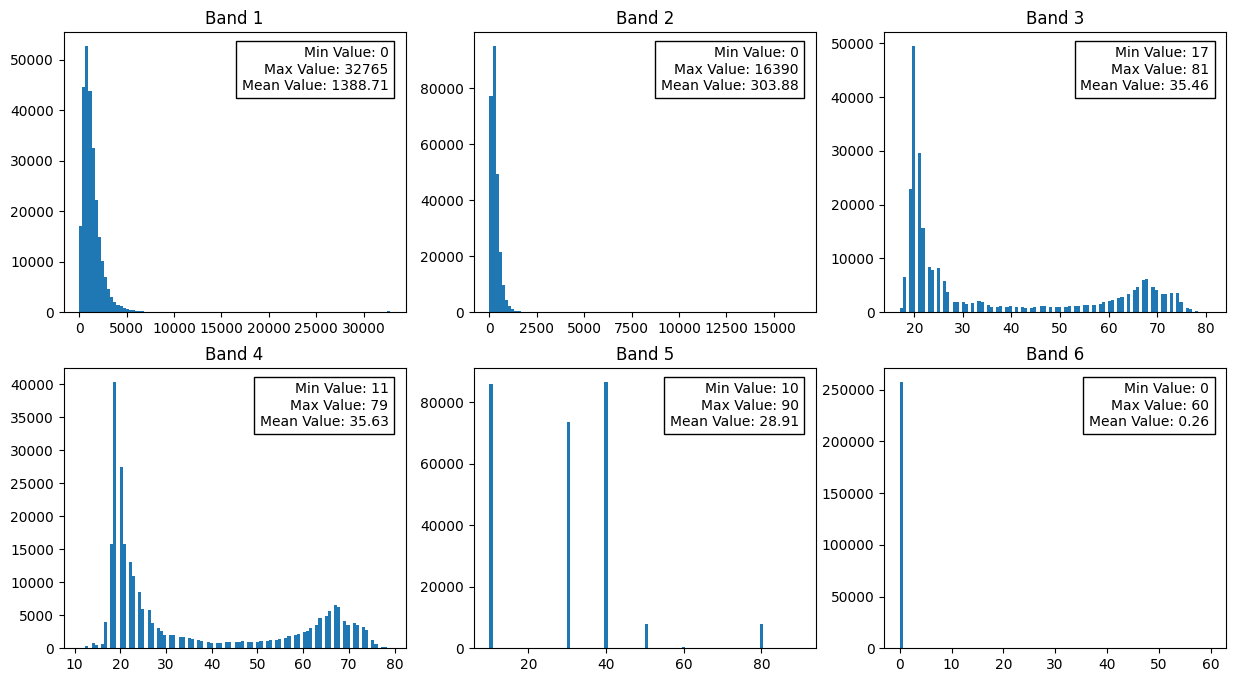

In [8]:
#plot the distribution of the features image.
plt.figure(figsize=(15,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(feature_img[i].ravel(), bins=100)
    plt.title("Band {}".format(i+1))
    plt.text(0.95, 0.95, "Min Value: {}".format(np.min(feature_img[i]))+'\n'+"Max Value: {}".format(np.max(feature_img[i]))+'\n'+"Mean Value: {}".format(round(np.mean(feature_img[i]),2)), ha='right', va='top', transform=plt.gca().transAxes,bbox=dict(facecolor = 'none',edgecolor = 'black'))

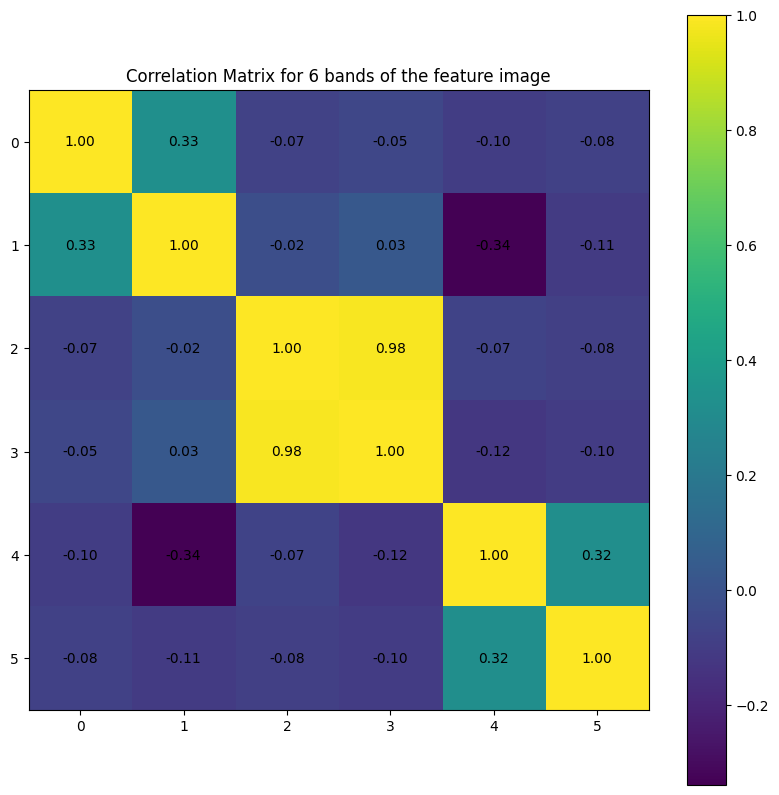

In [9]:
# Calculate the correlation matrix
corr_matrix = np.corrcoef(feature_img.reshape(6, -1), rowvar=True)

# Set up the figure
plt.figure(figsize=(10, 10))

# Display the correlation matrix
cax = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(cax)

# Add title
plt.title("Correlation Matrix for 6 bands of the feature image")

# Adding the correlation values as text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Show the plot
plt.show()

In [10]:
feature_img

array([[[1005, 1239,  892, ..., 3331, 2943, 1682],
        [ 804, 1069,  804, ..., 2365, 2943, 3124],
        [1193,  776,  504, ..., 1549, 3702, 5603],
        ...,
        [ 821,  598,  355, ..., 1666, 1100,  711],
        [ 920, 1179,  632, ..., 1494, 1014,  306],
        [ 666,  755, 1046, ..., 2541, 1308,  306]],

       [[  96,   74,  135, ...,  511,  496,   96],
        [  71,   38,   64, ...,  330,  496,  389],
        [ 200,  131,  107, ...,  115,  362,  402],
        ...,
        [ 322,  322,   64, ...,  280,  204,  143],
        [ 353,  493,  199, ...,  235,  156,  209],
        [ 246,  373,  464, ...,  286,  130,  209]],

       [[  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        ...,
        [  73,   73,   73, ...,   45,   45,   45],
        [  73,   73,   74, ...,   45,   45,   45],
        [  73,   74,   74, ...,   45,   45,   45]],

       [[  18,   18,   18, ...,   18,

In [11]:
#re-orgnize the feature image, so that the image can be used for training
feature_img = np.moveaxis(feature_img, 0, -1)
feature_img = feature_img.reshape(-1, 6)
label_img = label_img.reshape(-1)

In [12]:
feature_img

array([[1005,   96,   19,   18,   30,    0],
       [1239,   74,   19,   18,   30,    0],
       [ 892,  135,   19,   18,   30,    0],
       ...,
       [2541,  286,   45,   39,   10,    0],
       [1308,  130,   45,   40,   10,    0],
       [ 306,  209,   45,   41,   30,    0]], dtype=int16)

In [15]:
label_img.shape

(262144,)

In [57]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import os
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


#read all images
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

def read_all_image(img_folder):
#read all images in the folder
    feature_img_list = []
    for filename in os.listdir(img_folder):
        if filename.endswith(".tif"):
            feature_img_list.append(img_folder+filename)
    return feature_img_list

feature_img_list = read_all_image(feature_img_folder)

test_feature_img = np.empty((0,6))
test_label_img = np.empty((0))

for feature_img_path in feature_img_list:
    #print(feature_img_path)
    feature_img = rasterio.open(feature_img_path)
    feature_img = feature_img.read()
    feature_img = np.moveaxis(feature_img, 0, -1)
    feature_img = feature_img.reshape(-1, 6)
    
    scaler = StandardScaler()
    feature_img_scale = scaler.fit_transform(feature_img) 
    test_feature_img=+feature_img_scale
    #
    label_img_path = label_img_folder+feature_img_path.split('/')[-1].split('.')[0]+'.png'
    label_img = rasterio.open(label_img_path)
    label_img = label_img.read()
    label_img = label_img.reshape(-1)
    test_label_img=+label_img
    
X_train, X_test, y_train, y_test = train_test_split(test_feature_img, test_label_img, test_size=0.3, random_state=42)


def classification(method):
  start_time = time.time()
  method.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time
  y_pred = method.predict(X_test)
    
  return elapsed_time, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'),method


run_time_0, accuracy_0, F1_0,precision_0,recall_0, logisticRegr = classification(LogisticRegression(solver = 'lbfgs', multi_class='multinomial', max_iter=1000))
run_time_1, accuracy_1, F1_1,precision_1,recall_1, decisiontree = classification(tree.DecisionTreeClassifier())
run_time_2, accuracy_2, F1_2,precision_2,recall_2, randomforest= classification(RandomForestClassifier())
run_time_3, accuracy_3, F1_3,precision_3,recall_3, svmothed = classification(svm.SVC(max_iter=1000))
run_time_4, accuracy_4, F1_4,precision_4,recall_4, kneighbors = classification(KNeighborsClassifier())
run_time_5, accuracy_5, F1_5,precision_5,recall_5 ,neuralnetwork= classification(MLPClassifier(max_iter=500))
run_time_6, accuracy_6, F1_6,precision_6,recall_6, naivebayes = classification(GaussianNB())
run_time_7, accuracy_7, F1_7,precision_7,recall_7, xgboostmethod = classification(XGBClassifier())

result = pd.DataFrame(columns=['Method', 'Run Time', 'Accuracy', 'F1', 'Precision', 'Recall'])
result.loc[0] = ['Logistic Regression',run_time_0, accuracy_0, F1_0,precision_0,recall_0 ]
result.loc[1] = ['Decision Tree',run_time_1, accuracy_1, F1_1,precision_1,recall_1 ]
result.loc[2] = ['Random Forest',run_time_2, accuracy_2, F1_2,precision_2,recall_2 ]
result.loc[3] = ['Support Vector Machine',run_time_3, accuracy_3, F1_3,precision_3,recall_3]
result.loc[4] = ['K-Nearest Neighbors', run_time_4, accuracy_4, F1_4,precision_4,recall_4 ]
result.loc[5] = ['Neural Network', run_time_5, accuracy_5, F1_5,precision_5,recall_5]
result.loc[6] = ['Naive Bayes', run_time_6, accuracy_6, F1_6,precision_6,recall_6]
result.loc[7] = ['XGBoost', run_time_7, accuracy_7, F1_7,precision_7,recall_7]
result

,Method,Run Time,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.396247,0.988073,0.984679,0.986511,0.988073
1,Decision Tree,0.240102,0.989383,0.989530,0.989694,0.989383
2,Random Forest,7.782057,0.991798,0.991416,0.991220,0.991798
3,Support Vector Machine,6.765347,0.907240,0.939007,0.978197,0.907240
4,K-Nearest Neighbors,0.176993,0.989179,0.988394,0.987988,0.989179
5,Neural Network,17.981294,0.990591,0.988564,0.990261,0.990591
6,Naive Bayes,0.026996,0.989141,0.986481,0.988095,0.989141
7,XGBoost,0.284062,0.991582,0.990902,0.990767,0.991582


# HDC

In [10]:
feature_img

array([[ 502,  244,   56,   66,   10,    0],
       [ 675,  189,   55,   66,   10,    0],
       [ 472,  342,   55,   65,   10,    0],
       ...,
       [1300,   43,   35,   34,   40,    0],
       [2631,  110,   35,   34,   40,    0],
       [2879,   96,   35,   34,   40,    0]], dtype=int16)

In [11]:
feature_img.shape

(262144, 6)

In [12]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler


# Normalize features
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

# Convert to torch
feature_tensor = torch.tensor(feature_img_scaled, dtype=torch.float32)

# Step 2: Define HDC parameters
D = 1024  # Dimension of hypervectors
F = feature_tensor.shape[1]  # 6 feature dimensions

# Step 3: Create position hypervectors (random bipolar)
torch.manual_seed(42)
position_hv = torch.randint(0, 2, (F, D)).float()
position_hv[position_hv == 0] = -1  # convert to bipolar {-1, +1}

# Step 4: Bind each feature to its position
# Use feature value as scalar modulator on its position vector
# Expand and multiply (binding)
bound_vectors = feature_tensor.unsqueeze(2) * position_hv  # shape: (N, F, D)

# Step 5: Bundle (sum across feature dimensions)
hypervectors = bound_vectors.sum(dim=1)  # shape: (N, D)

# Optional: normalize or threshold
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)

# hypervectors is your final encoded representation for each pixel
print(hypervectors.shape)  # should be (262144, 1024)

torch.Size([262144, 1024])


In [13]:
hypervectors

tensor([[-0.0312, -0.0648, -0.0016,  ...,  0.0147, -0.0108, -0.0108],
        [-0.0363, -0.0655, -0.0088,  ...,  0.0081, -0.0095, -0.0075],
        [-0.0249, -0.0617,  0.0031,  ...,  0.0205, -0.0065, -0.0175],
        ...,
        [-0.0063,  0.0327, -0.0016,  ..., -0.0319, -0.0349,  0.0385],
        [-0.0203,  0.0459, -0.0166,  ..., -0.0397, -0.0055,  0.0447],
        [-0.0223,  0.0449, -0.0190,  ..., -0.0402, -0.0024,  0.0449]])

In [18]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load full image ===
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 6)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === HDC Setup ===
D = 512
F = features.shape[1]
BATCH_SIZE = 16

torch.manual_seed(42)
position_vectors = torch.randint(0, 2, (F, D), dtype=torch.float32, device=device)
position_vectors[position_vectors == 0] = -1

# === HDC Encoding in batches of 16 ===
def encode_hdc_batchwise(x, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        bound = batch.unsqueeze(2) * position_vectors  # (B, F, D)
        bundled = bound.sum(dim=1)
        encoded.append(torch.nn.functional.normalize(bundled, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_batchwise(features, batch_size=BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build Class Hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

total_time = time.time() - total_start

# === Report ===
print("\n=== HDC Classification on Full Image (Batch Size = 16) ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== HDC Classification on Full Image (Batch Size = 16) ===
Accuracy : 0.5176
F1 Score : 0.6819
Precision: 0.9998
Recall   : 0.5176

=== Runtime Summary ===
Data Loading Time    : 0.1275 sec
Encoding Time        : 2.7091 sec
Training Time        : 0.0706 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 3.1741 sec


# One-short

In [26]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import qmc
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load full image ===
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 6)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize features
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === HDC Setup with Sobol Projection ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

# Generate Sobol projection matrix on CPU, then move to GPU
sobol = qmc.Sobol(d=F, scramble=False)
sobol_matrix = torch.tensor(sobol.random(n=D).T, dtype=torch.float32, device=device)  # (F, D)

# === HDC Encoding in batches ===
def encode_hdc_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)  # (B, D)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_batchwise(features, sobol_matrix, batch_size=BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build Class Hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

total_time = time.time() - total_start

# === Report ===
print("\n=== HDC Classification with Sobol Projection ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== HDC Classification with Sobol Projection ===
Accuracy : 0.6274
F1 Score : 0.7708
Precision: 0.9998
Recall   : 0.6274

=== Runtime Summary ===
Data Loading Time    : 0.0729 sec
Encoding Time        : 1.4474 sec
Training Time        : 8.4327 sec
Inference Time       : 0.0010 sec
Total Pipeline Time  : 10.4952 sec


# Iterative

In [51]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import qmc
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 6)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === HDC Setup with Sobol + Bipolar Encoding ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

# Generate Sobol matrix and convert to bipolar {-1, +1}
sobol = qmc.Sobol(d=F, scramble=False)
sobol_matrix = torch.tensor(sobol.random(n=D).T, dtype=torch.float32, device=device)  # shape (F, D)
sobol_matrix = (sobol_matrix > 0.5).float() * 2 - 1  # Convert to bipolar

# === Encoding function ===
def encode_hdc_bipolar_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)  # (B, D)
        proj = torch.sign(proj)
        proj[proj == 0] = 1
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_bipolar_batchwise(features, sobol_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build Class Hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === GPU Cosine Classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# === Retraining function ===
def retrain(class_hv, X_proj, y_true, num_retrain_epochs=3, update_factor=0.1):
    class_hv = class_hv.clone()
    for epoch in range(num_retrain_epochs):
        for i in range(X_proj.shape[0]):
            sample = X_proj[i].unsqueeze(0)
            true_cls = y_true[i].item()
            pred_cls = classify_gpu(sample, class_hv)[0].item()

            if pred_cls != true_cls:
                class_hv[pred_cls] -= update_factor * sample.squeeze(0)
                class_hv[true_cls] += update_factor * sample.squeeze(0)

        class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    return class_hv

# === Retraining ===
class_hv = retrain(class_hv, hypervectors, labels, num_retrain_epochs=3, update_factor=0.05)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== HDC Classification with Sobol ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== HDC Classification with Sobol ===
Accuracy : 0.6719
F1 Score : 0.8036
Precision: 0.9994
Recall   : 0.6719

=== Runtime Summary ===
Data Loading Time    : 0.0825 sec
Encoding Time        : 2.7546 sec
Training Time        : 8.5600 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 188.2320 sec


# Quantum-HDC

# One-short

In [54]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 6)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === Quantum projection using 6-qubit Hadamard circuits ===
def generate_quantum_hypervector_6qubit(D):
    num_qubits = 6
    num_shots = ceil(D / num_qubits)
    
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = AerSimulator()
    transpiled = transpile(qc, backend)
    result = backend.run(transpiled, shots=num_shots).result()
    counts = result.get_counts()

    all_bits = []
    for bitstring, count in counts.items():
        bits = [1 if b == '1' else -1 for b in reversed(bitstring)]
        all_bits.extend(bits * count)

    all_bits = np.array(all_bits[:D]) if len(all_bits) >= D else np.pad(all_bits, (0, D - len(all_bits)), constant_values=-1)
    return all_bits

# === Create full projection matrix ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

projection_matrix = []
for _ in range(F):
    projection_matrix.append(generate_quantum_hypervector_4qubit(D))
projection_matrix = torch.tensor(np.stack(projection_matrix), dtype=torch.float32, device=device)  # (F, D)

# === Encode features in batches ===
def encode_hdc_float_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_float_batchwise(features, projection_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build class hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Cosine classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== Quantum HDC Classification ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== Quantum HDC Classification ===
Accuracy : 0.5158
F1 Score : 0.6804
Precision: 0.9998
Recall   : 0.5158

=== Runtime Summary ===
Data Loading Time    : 0.1436 sec
Encoding Time        : 1.5599 sec
Training Time        : 8.2637 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 11.0985 sec


# Iterative

In [55]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track1/train/images/"
label_img_folder = "Track1/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 6)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === Quantum projection using 6-qubit Hadamard circuits ===
def generate_quantum_hypervector_6qubit(D):
    num_qubits = 6
    num_shots = ceil(D / num_qubits)
    
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = AerSimulator()
    transpiled = transpile(qc, backend)
    result = backend.run(transpiled, shots=num_shots).result()
    counts = result.get_counts()

    all_bits = []
    for bitstring, count in counts.items():
        bits = [1 if b == '1' else -1 for b in reversed(bitstring)]
        all_bits.extend(bits * count)

    all_bits = np.array(all_bits[:D]) if len(all_bits) >= D else np.pad(all_bits, (0, D - len(all_bits)), constant_values=-1)
    return all_bits

# === Create full projection matrix ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

projection_matrix = []
for _ in range(F):
    projection_matrix.append(generate_quantum_hypervector_6qubit(D))
projection_matrix = torch.tensor(np.stack(projection_matrix), dtype=torch.float32, device=device)  # (F, D)

# === Encode features in batches ===
def encode_hdc_float_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_float_batchwise(features, projection_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build class hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Cosine classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# === Retraining function ===
def retrain(class_hv, X_proj, y_true, num_retrain_epochs=3, update_factor=0.1):
    class_hv = class_hv.clone()
    for epoch in range(num_retrain_epochs):
        for i in range(X_proj.shape[0]):
            sample = X_proj[i].unsqueeze(0)
            true_cls = y_true[i].item()
            pred_cls = classify_gpu(sample, class_hv)[0].item()
            if pred_cls != true_cls:
                class_hv[pred_cls] -= update_factor * sample.squeeze(0)
                class_hv[true_cls] += update_factor * sample.squeeze(0)
        class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    return class_hv

# === Retrain ===
class_hv = retrain(class_hv, hypervectors, labels, num_retrain_epochs=3, update_factor=0.05)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== Quantum HDC Classification ==")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")


Using device: cuda

=== Quantum HDC Classification ==
Accuracy : 0.6956
F1 Score : 0.8202
Precision: 0.9998
Recall   : 0.6956

=== Runtime Summary ===
Data Loading Time    : 0.0788 sec
Encoding Time        : 1.9977 sec
Training Time        : 8.5105 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 183.5570 sec
